In [39]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.tseries.offsets import *
from xbbg import blp
import sys
sys.path.append(r'\\10.5.20.31\交易部\Blair\backTestTool')
sys.path.append(r'\\10.5.20.31\交易部\FX trading Strategy souce code\Wilson\程式碼')
sys.path.append(r'C:\Users\Blair Lin\quantTrade_2024')
import portStats

import sys
from contextlib import contextmanager
import io
import os

# Add this at the beginning of your code, after the imports
strgyName = '1104'
traderName = 'Blair'

devCcy =  ['EUR', 'JPY', 'GBP', 'CHF', 'AUD', 'CAD', 'NZD', 'SEK']
revL = ['NZD', 'EUR', 'AUD', 'GBP']
basket = ['EUR', 'JPY', 'GBP', 'CHF', 'AUD', 'CAD', 'NZD', 'SEK', 'INR', 'IDR', 'ZAR', 'CNH', 'SGD']
# basket=['EUR', 'JPY', 'CHF', 'AUD']

In [40]:
from datetime import datetime
today = datetime.now()+pd.Timedelta(days=0)
today_str = today.strftime('%Y-%m-%d')
startDate = today-pd.Timedelta(days=600)

# startDate = startDate.strftime('%Y-%m-%d')
startDate = '2012-01-01'
endDate = today_str

dr = pd.date_range(
    start=pd.to_datetime(startDate),
    end=pd.to_datetime(endDate),
    freq=BDay()
) 


df = pd.DataFrame(index=dr)

df['US2Y'] = blp.bdh(tickers='USGG2YR Index', flds = ["PX_LAST"], start_date=startDate, end_date=endDate)
df['US10Y'] = blp.bdh(tickers='USGG10YR Index', flds = ["PX_LAST"], start_date=startDate, end_date=endDate)
df['us2y10y'] = df['US2Y'] - df['US10Y']

df['VIX'] = blp.bdh(tickers='VIX Index', flds = ["PX_LAST"], start_date=startDate, end_date=endDate)

df['emRet'] = blp.bdh(tickers='M1EF Index', flds = ["PX_LAST"], start_date=startDate, end_date=endDate) * -1
df['rr'] = blp.bdh(tickers='USDJPY25R1M BGN Curncy', flds = ["PX_LAST"], start_date=startDate, end_date=endDate) * -1
df['fxVol'] = blp.bdh(tickers='CVIX Index', flds = ["PX_LAST"], start_date=startDate, end_date=endDate)


df = df.iloc[1:, ]
df.drop(columns=['US2Y', 'US10Y'], inplace=True)
df.fillna(method='ffill', inplace=True)
df = df.shift(1)


In [41]:
# df.to_csv('macroRiskComponent_shifted.csv')

In [42]:
### get original signal
def rolling_percentile(data, window=150, min_periods=None):
    """
    calculate rolling percnetile over specific window
    """
    if min_periods is None:
        min_periods = window

    def percentile_rank(window):
        current = window.iloc[-1]
        # print(window, current)
        # print((window <= current).mean())
        return pd.Series([(window <= current).mean() * 100])

    return data.rolling(window=window, min_periods=min_periods).apply(percentile_rank)

def updateW(col):
    count = 0
    pos = 0


    for x in col:
        raw = mri.iloc[count]
        ma = mriMA.iloc[count]

        if (raw > ma):
            if pos == 0:
                # print(f'目前 MRI 為: {raw}，開倉做空風險貨幣')
                pos = -1
            elif pos == 1:
                #print(f'目前 MRI 為: {raw}，關閉做多的風險貨幣')
                pos = 0
        elif (raw < ma) & (pos != 0):
            # if pos == 0:
            #     print(f'目前 MRI 為: {raw}，承平時刻，做多風險貨幣')
            #     pos = 1
            if pos == -1:
                #print(f'目前 MRI 為: {raw}，關閉做空的風險貨幣')
                pos = 0  
        elif (raw < ma) & (pos == 0):
            pass
        col[count] = pos
        count += 1

    return col

roll_Pctl = pd.DataFrame(index=dr, columns=df.columns)
for asset in roll_Pctl.columns:
    roll_Pctl[asset] = rolling_percentile(df[asset])

roll_Pctl['simple_avg'] = roll_Pctl.mean(axis=1)

mri = roll_Pctl['simple_avg'].copy()
mriMA = mri.rolling(20).mean()

signalDf = pd.DataFrame(index=dr, columns=basket)
signalDf = signalDf.apply(updateW, axis=0)

In [43]:
mri2 = pd.DataFrame(mri)
mri2.columns=['mri']

In [44]:
tickerMap = dict(zip(df.columns, ['USGG2YR Index', 'VIX Index', 'M1EF Index', 'USDJPY25R1M BGN Curncy', 'CVIX Index']))
tickerMap


{'us2y10y': 'USGG2YR Index',
 'VIX': 'VIX Index',
 'emRet': 'M1EF Index',
 'rr': 'USDJPY25R1M BGN Curncy',
 'fxVol': 'CVIX Index'}

In [45]:
def calculate_vix_dxy_correlation(start_date, end_date, asset, rolling_window):
    """
    Calculates the historical rolling correlation between VIX and DXY
    
    Parameters:
    start_date (str): Start date in 'YYYY-MM-DD' format
    end_date (str): End date in 'YYYY-MM-DD' format
    rolling_window (int): Window size for rolling correlation
    
    Returns:
    pd.DataFrame: DataFrame with VIX, DXY, and their rolling correlation
    """
    # Create date range
    dr_corr = pd.date_range(
        start=pd.to_datetime(start_date),
        end=pd.to_datetime(end_date),
        freq=BDay()
    )
    

    
    # Get VIX and DXY data for the full period
    vix_data = blp.bdh(tickers=asset, flds=["PX_LAST"], 
                       start_date=start_date, end_date=end_date)
    if asset == 'USGG2YR Index':
        vix_data1 = blp.bdh(tickers='USGG2YR Index', flds=["PX_LAST"], 
                        start_date=start_date, end_date=end_date)
        vix_data2 = blp.bdh(tickers='USGG10YR Index', flds=["PX_LAST"], 
                        start_date=start_date, end_date=end_date)
        vix_data = vix_data1['USGG2YR Index']-vix_data2['USGG10YR Index']
        # print(vix_data)
    
    if asset == 'mri':
        vix_data = mri2['mri'].copy()
    
    dxy_data = blp.bdh(tickers='DXY Index', flds=["PX_LAST"], 
                       start_date=start_date, end_date=end_date)
    
    # Combine into a single DataFrame and handle any missing values
    corr_df = pd.DataFrame(index=dr_corr)
    corr_df['VIX'] = vix_data
    corr_df['DXY'] = dxy_data
    corr_df = corr_df.fillna(method='ffill')
    
    # Calculate daily returns
    corr_df['VIX_ret'] = corr_df['VIX'].pct_change()
    corr_df['DXY_ret'] = corr_df['DXY'].pct_change()
    
    # Calculate rolling correlation
    corr_df['rolling_corr'] = corr_df['VIX_ret'].rolling(window=rolling_window).corr(corr_df['DXY_ret'])
    
    # Add a few useful columns
    corr_df['rolling_corr_mean'] = corr_df['rolling_corr'].rolling(window=252).mean()
    corr_df['rolling_corr_std'] = corr_df['rolling_corr'].rolling(window=252).std()
    corr_df['corr_z_score'] = (corr_df['rolling_corr'] - corr_df['rolling_corr_mean']) / corr_df['rolling_corr_std']
    
    return corr_df

In [46]:
tickerMap

{'us2y10y': 'USGG2YR Index',
 'VIX': 'VIX Index',
 'emRet': 'M1EF Index',
 'rr': 'USDJPY25R1M BGN Curncy',
 'fxVol': 'CVIX Index'}

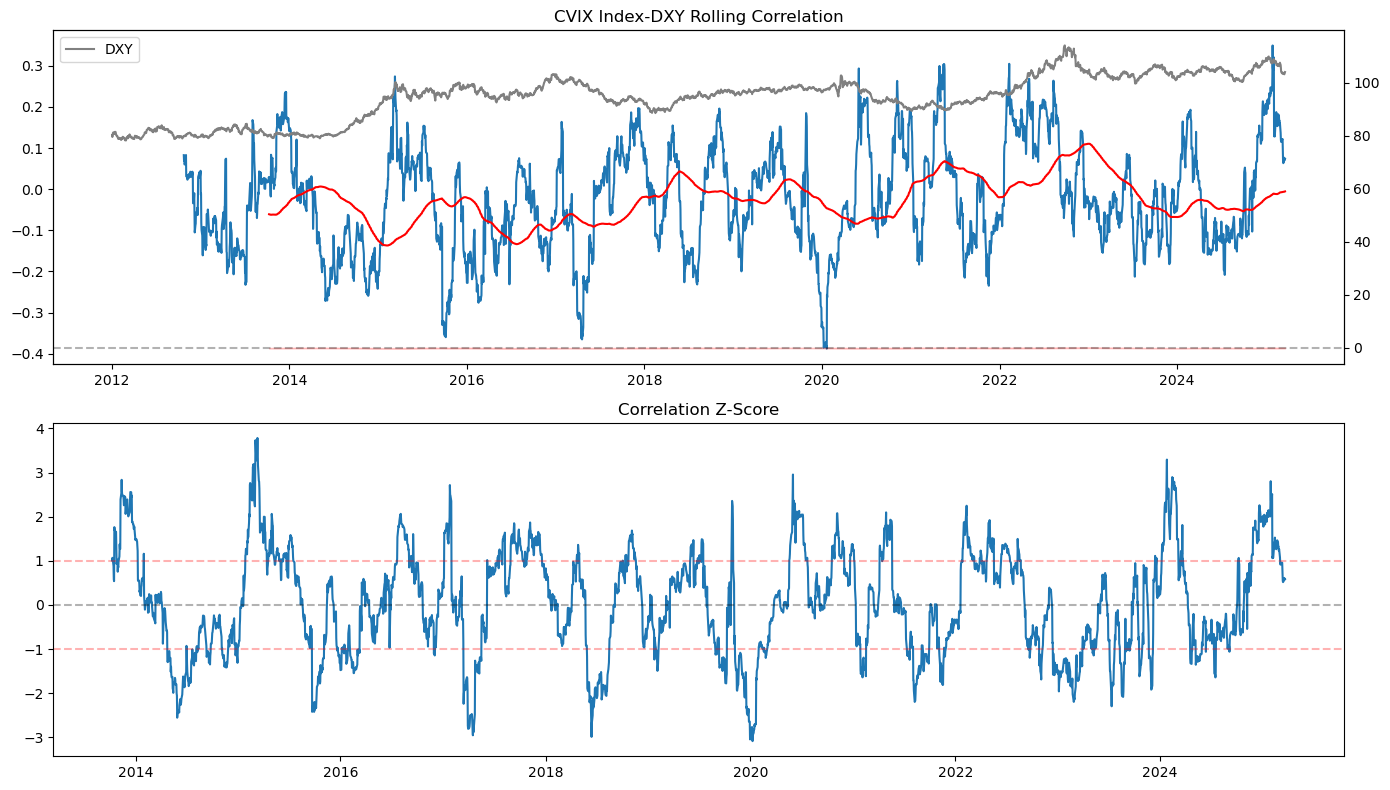

In [47]:
# corr_df = calculate_vix_dxy_correlation(startDate, endDate, asset=tickerMap['VIX'], rolling_window=60)
corr_df = calculate_vix_dxy_correlation(startDate, endDate, asset='mri', rolling_window=60)
# corr_df = corr_df[corr_df.index.year == 2025]
corr_df.to_csv(f'{today_str}_VIX_DXY_Correlation.csv')

# Create a plot to visualize the correlation over time
plt.figure(figsize=(14, 8))
plt.subplot(211)
plt.plot(corr_df.index, corr_df['rolling_corr'], label='60-day Rolling Correlation')
plt.plot(corr_df.index, corr_df['rolling_corr_mean'], label='1-Year Average', color='red')
plt.twinx()
plt.plot(corr_df.index, corr_df['DXY'], label='DXY', color='grey')

plt.fill_between(corr_df.index, 
                corr_df['rolling_corr_mean'] - corr_df['rolling_corr_std'], 
                corr_df['rolling_corr_mean'] + corr_df['rolling_corr_std'], 
                alpha=0.2, color='red')
plt.axhline(y=0, color='black', linestyle='--', alpha=0.3)
plt.legend()
plt.title(f'{tickerMap['fxVol']}-DXY Rolling Correlation')

plt.subplot(212)
plt.plot(corr_df.index, corr_df['corr_z_score'])
plt.axhline(y=0, color='black', linestyle='--', alpha=0.3)
plt.axhline(y=1, color='red', linestyle='--', alpha=0.3)
plt.axhline(y=-1, color='red', linestyle='--', alpha=0.3)
plt.title('Correlation Z-Score')
plt.tight_layout()
# plt.savefig(f'{today_str}_VIX_DXY_Correlation.png')
# plt.close()

In [48]:
corr_df.tail(10)

,VIX,DXY,VIX_ret,DXY_ret,rolling_corr,rolling_corr_mean,rolling_corr_std,corr_z_score
2025-03-10,61.333333,103.900,0.017699,0.000597,0.120571,-0.007086,0.134641,0.948130
2025-03-11,59.866667,103.419,-0.023913,-0.004629,0.121867,-0.006879,0.134799,0.955098
2025-03-12,60.666667,103.612,0.013363,0.001866,0.097159,-0.006637,0.134931,0.769254
2025-03-13,54.000000,103.828,-0.109890,0.002085,0.067287,-0.006517,0.134984,0.546760
2025-03-14,55.200000,103.718,0.022222,-0.001059,0.063289,-0.006403,0.135031,0.516123
2025-03-17,51.333333,103.370,-0.070048,-0.003355,0.068073,-0.006311,0.135074,0.550694
2025-03-18,45.200000,103.244,-0.119481,-0.001219,0.076439,-0.006097,0.135162,0.610646
2025-03-19,39.600000,103.428,-0.123894,0.001782,0.070405,-0.005883,0.135241,0.564087
2025-03-20,40.800000,103.851,0.030303,0.004090,0.072607,-0.005678,0.135321,0.578511
2025-03-21,42.000000,104.088,0.029412,0.002282,0.073729,-0.005390,0.135413,0.584279


In [49]:
def updateW_with_corr_regime(col):
    count = 0
    pos = 0
    
    for x in col:
        raw = mri.iloc[count]
        ma = mriMA.iloc[count]
        
        # Get the date for this row
        current_date = dr[count]
        
        # Get correlation information for this date if available
        try:
            current_corr = corr_df.loc[current_date, 'rolling_corr']
            current_z = corr_df.loc[current_date, 'corr_z_score']
            regime_valid = current_corr > 0  # Adjust threshold as needed
        except:
            # Default to True if we don't have correlation data
            regime_valid = True
            current_corr = 0
            current_z = 0
        
        if (raw > ma):
            if pos == 0 and regime_valid:
                # Only take new positions if correlation regime is valid
                pos = -1
            elif pos == 1:
                pos = 0
        elif (raw < ma) & (pos != 0):
            if pos == -1:
                pos = 0  
        elif (raw < ma) & (pos == 0):
            pass
            
        # Scale position by correlation strength if needed
        # Uncomment to enable position scaling
        # if pos != 0:
        #     scale_factor = min(1.0, max(0.25, abs(current_corr)))
        #     pos = pos * scale_factor
            
        col[count] = pos
        count += 1

    return col

In [50]:
signalDf = signalDf.apply(updateW_with_corr_regime, axis=0)

for ccy in signalDf:
    if ccy not in revL:
        signalDf[ccy] = -1*signalDf[ccy] # 將訊號轉為市場慣例 (USDJPY +1 為 long USDJPY, EURUSD +1 為 long EURUSD)
signalDf = signalDf * (1/len(basket)) 
# weight_size = 4
# signalDf = signalDf * weight_size

In [51]:
# ## get market data
# from xbbg import blp

# basket = signalDf.columns
# ohlcTickers = [ f'{i} CMTK Curncy' for i in basket]
# ohlc = pd.DataFrame(columns=basket)

# instruments = ohlcTickers

# ohlcD = dict.fromkeys(basket)
# for k in ohlcD.keys():
#     ohlcD[k] = pd.DataFrame(columns=['PX_OPEN', 'PX_LAST', 'PX_LOW', 'PX_HIGH'])

# count = 0
# for i in instruments:
#     for fld in ['PX_OPEN', 'PX_LAST', 'PX_LOW', 'PX_HIGH']:
#         # tmpS = blp.bdh(tickers=instruments[count], flds=fld, start_date=startDate, end_date=endDate).shift(1)
#         tmpS = blp.bdh(tickers=instruments[count], flds=fld, start_date=startDate, end_date=endDate)
#         ohlcD[basket[count]][fld] = tmpS
#         tmpIdx = tmpS.index
#         ohlcD[basket[count]].index = pd.DatetimeIndex(ohlcD[basket[count]].index)
#         # if fld == 'PX_HIGH':
#         #     ohlcD[basket[count]].index = tmpIdx
#     count += 1

# ohlc.index = pd.DatetimeIndex(ohlc.index)
# np.save('ohlc_BGN_EM.npy', ohlcD)

In [52]:
# backtest
ohlcD = np.load('ohlc_BGN_EM.npy',allow_pickle='TRUE').item()
spot = pd.DataFrame(index=dr, columns=basket)
for col in spot.columns:
    spot[col] = ohlcD[col]['PX_LAST']
spot.tail()

,EUR,JPY,GBP,CHF,AUD,CAD,NZD,SEK,INR,IDR,ZAR,CNH,SGD
2025-03-17,1.0876,148.84,1.2936,0.8839,0.6338,1.4363,0.5769,10.1316,86.8278,16404.0,18.2096,7.2425,1.3339
2025-03-18,1.0935,149.83,1.2987,0.8810,0.6380,1.4294,0.5823,10.0772,86.6188,16426.0,18.0329,7.2273,1.3308
2025-03-19,1.0893,149.28,1.2971,0.8773,0.6331,1.4327,0.5789,10.1053,86.5496,16529.0,18.2276,7.2396,1.3336
2025-03-20,1.0879,148.59,1.2972,0.8773,0.6321,1.4341,0.5771,10.1257,86.3685,16484.0,18.1623,7.2419,1.3329
2025-03-21,1.0839,149.31,1.2935,0.8834,0.6295,1.4323,0.5758,10.1077,86.0381,16500.0,18.2137,7.2523,1.3346


<Axes: >

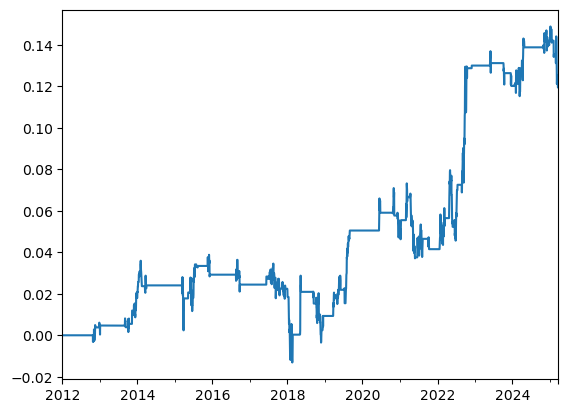

In [53]:
# 取的每日損益
btSpot = spot.copy()
btSpot.index = pd.DatetimeIndex(btSpot.index)
btSpot = btSpot.reindex(dr).ffill()

global btDailyRet 
btDailyRet = (btSpot-btSpot.shift(1))/btSpot

portDailyChange = btDailyRet * signalDf.shift(1)
portDailyChange['port'] = portDailyChange.sum(axis=1)
portDailyChange['port'].cumsum().plot()

In [54]:
def getStats(totalCount, dailyS, cumS):
    s = pd.Series()
    # s['Mean'] = (1 + cumS[-1]) ** (250 / totalCount) - 1
    # s['Mean'] = (1+dailyS[1:].sum()/totalCount) * 250 - 1

    if totalCount >= 252:
        s['Mean'] = (dailyS[0:].sum()) / totalCount * 252
        s['Std'] = (dailyS[0:].std()) * np.sqrt(252)
    else:
        s['Mean'] = (dailyS[0:].sum()) / totalCount * totalCount
        s['Std'] = (dailyS[0:].std()) * np.sqrt(totalCount)

    s['Sharpe'] = s['Mean'] / s['Std']
    # mddForPlot = maxDDVer3(cumS)[0]
    # periodHigh = maxDDVer3(cumS)[1]
    # s['MDD'] = np.min(mddForPlot)
                                                                                                 
    return s

In [55]:
getStats(totalCount=portDailyChange.shape[0], dailyS=portDailyChange['port'], cumS=portDailyChange['port'].cumsum())

Mean      0.008726
Std       0.026490
Sharpe    0.329388
dtype: float64

In [56]:
tmp = portDailyChange[portDailyChange.index.year <= 2023]
getStats(totalCount=tmp.shape[0], dailyS=tmp['port'], cumS=tmp['port'].cumsum())

Mean      0.009678
Std       0.026084
Sharpe    0.371017
dtype: float64

In [57]:
tmp = portDailyChange[portDailyChange.index.year == 2025]
getStats(totalCount=tmp.shape[0], dailyS=tmp['port'], cumS=tmp['port'].cumsum())

Mean     -0.023238
Std       0.021009
Sharpe   -1.106070
dtype: float64